<a href="https://colab.research.google.com/github/khadkaabishek/Agentic-AI/blob/main/Chapter5_dcGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# cell-1
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### Data Preparation
* We will be using MNIST dataset which can be easily downloaded from torchvision-datasets.

* We will be using only images from that dataset not labels (unsupervised learning).

In [ ]:
# cell-2
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.81MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.3MB/s]


Visualization of MNIST Dataset Samples

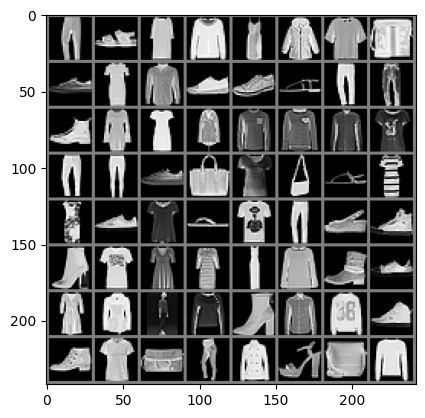

Shape of a batch of images: torch.Size([64, 1, 28, 28])


In [ ]:
# cell-3
def imshow(img):
    img = img / 2 + 0.5  # Denormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

def show_grid(images):
    img_grid = torchvision.utils.make_grid(images, nrow=8)
    imshow(img_grid)

# Get some random training images
trainloader_for_vis = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
dataiter = iter(trainloader_for_vis)
images, labels = next(dataiter)

# Display the images in a grid
show_grid(images)

print(f"Shape of a batch of images: {images.shape}")

### Building Discriminator Network

* Discriminator is a classfier.

* Input: Image

* Ouput: Real or Fake

* We will be building a simple discriminator using Mulit-layer Perceptron.

* Do not forget to flatten the image since we will be using linear layers.

* Keep the architecture as simple as possible.

In [ ]:


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: (1, 28, 28)
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # (64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4),  # (1, 1, 1)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x.view(-1, 1)  # Flatten to (batch_size, 1)


### Building Generator Network

* We will be building simple generator network which is also a multi-layer perceptron network.

* Input to the generator will be a vector which is known as latent vector or noise vector.

* The dimension of latent vector is a hyperparameter. Let's use latent vector of dimension 100.

* Latent vector is usually sampled from normal distribution.

* Output of the generator will be a vector of dimension equal to training image dimension.

* Do not forget to reshape the output vector to 2d-image shape same as training image dimension.

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: (batch_size, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),  # (256, 7, 7)
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),  # (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, z):
        # reshape latent vector to (batch_size, latent_dim, 1, 1)
        z = z.view(z.size(0), z.size(1), 1, 1)
        return self.main(z)


### Objective Function for GAN

**Discriminator Objective Function**

* Discriminator objective is to classify real image as 1 and fake image as 0.

* Discriminator is trained with both real images and fake images.

* Discriminator loss consists of two parts:

    1. real_data_loss: The loss when the discriminator correctly identifies real data as real.

    2. fake_data_loss: The loss when the discriminator correctly identifies fake data as fake.

* Since discriminator formulates binary classification problem, both real_data_loss and fake_data_loss are BinaryCrossEntropy Loss.

* Total discriminator loss = real_data_loss + fake_data_loss

* Objective: **Minimize(real_data_loss + fake_data_loss)**


**Generator Objective Function**
* Generator objective is to generate images that looks realistic. In other words, generator objective is to fool discriminator. In other words, generator objective is to increase discriminator loss and decrease discriminator accuracy.

* If the image generated by generator is classified as fake by discriminator, then generator_loss should increase. (In this scenario, generator fails to achieve its objective of fooling discriminator)

* If the image generated by generator is classified as real by discriminator, then generator_loss should decrease. (In this scenario, generator succeed to achieve its objective of fooling discriminator)

* We use BinaryCrossEntropy as loss for generator.

### Training GAN

* Training GAN involve training Discriminator and Generator alternatively.

In [ ]:
# cell-6
# Using available hardware device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# device = "cpu"
# Creating the generator and discriminator
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# creating binary cross entropy loss instancea
criterion = nn.BCELoss()

# creating optimizers for generator and discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): Tanh()
  )
)

In [ ]:
discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [ ]:
device

device(type='cuda')

In [ ]:
# cell-7
# Containers to store losses for visualization purpose
num_epochs = 20
discriminator_loss = []
generator_loss = []

### Steps for Training Discriminator

1. Infer discriminator with a mini-batch of real images from training set.
2. Calculate loss for discriminator with real data.
3. Generate latent vector from normal distribution for mini-batch.
4. Generate fake image by feeding latent vector to generator.
5. Infer discriminator with fake images.
6. Calulate loss for discriminator with fake data.
7. Compute total loss by adding both losses
8. Compute the gradient of total discriminator loss and update the discriminator optimizer parameters.

### Steps for Training Generator
1. Generate latent vector from normal distribution for mini-batch.
2. Generate fake image by feeding latent vector to generator.
3. Infer the discriminator with fake image.
4. Calculate loss for generator.
5. Compute the gradient of generator loss and update its optimizer parameters.

Epoch [1/20], Step [200/938], d_loss: 0.0043, g_loss: 6.6491, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [400/938], d_loss: 0.0351, g_loss: 5.8582, D(x): 0.98, D(G(z)): 0.01
Epoch [1/20], Step [600/938], d_loss: 0.0011, g_loss: 7.2648, D(x): 1.00, D(G(z)): 0.00
Epoch [1/20], Step [800/938], d_loss: 0.0002, g_loss: 9.1201, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [200/938], d_loss: 0.0001, g_loss: 10.4235, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [400/938], d_loss: 0.0000, g_loss: 10.8929, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [600/938], d_loss: 0.0000, g_loss: 10.6594, D(x): 1.00, D(G(z)): 0.00
Epoch [2/20], Step [800/938], d_loss: 0.0000, g_loss: 11.0683, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [200/938], d_loss: 0.0000, g_loss: 11.1561, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [400/938], d_loss: 0.0000, g_loss: 10.8358, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [600/938], d_loss: 0.0000, g_loss: 11.5545, D(x): 1.00, D(G(z)): 0.00
Epoch [3/20], Step [800/9

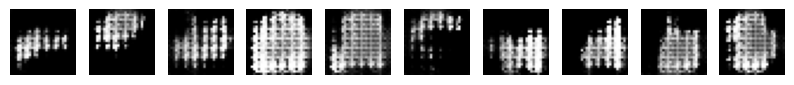

Epoch [6/20], Step [200/938], d_loss: 0.0535, g_loss: 5.1580, D(x): 0.99, D(G(z)): 0.04
Epoch [6/20], Step [400/938], d_loss: 0.2032, g_loss: 4.4579, D(x): 0.85, D(G(z)): 0.02
Epoch [6/20], Step [600/938], d_loss: 0.1246, g_loss: 5.3214, D(x): 0.92, D(G(z)): 0.02
Epoch [6/20], Step [800/938], d_loss: 0.6786, g_loss: 2.1704, D(x): 0.70, D(G(z)): 0.15
Epoch [7/20], Step [200/938], d_loss: 0.3591, g_loss: 2.8770, D(x): 0.88, D(G(z)): 0.13
Epoch [7/20], Step [400/938], d_loss: 0.3068, g_loss: 4.2001, D(x): 0.89, D(G(z)): 0.14
Epoch [7/20], Step [600/938], d_loss: 0.3046, g_loss: 3.5323, D(x): 0.96, D(G(z)): 0.19
Epoch [7/20], Step [800/938], d_loss: 0.3116, g_loss: 2.7635, D(x): 0.88, D(G(z)): 0.11
Epoch [8/20], Step [200/938], d_loss: 0.2705, g_loss: 3.1779, D(x): 0.85, D(G(z)): 0.08
Epoch [8/20], Step [400/938], d_loss: 0.5108, g_loss: 3.2481, D(x): 0.72, D(G(z)): 0.07
Epoch [8/20], Step [600/938], d_loss: 0.3826, g_loss: 2.9612, D(x): 0.87, D(G(z)): 0.16
Epoch [8/20], Step [800/938], d_

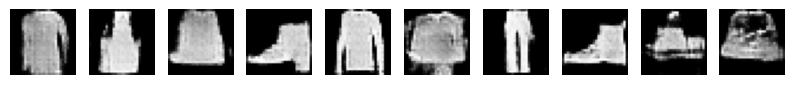

Epoch [11/20], Step [200/938], d_loss: 0.2767, g_loss: 2.5904, D(x): 0.93, D(G(z)): 0.15
Epoch [11/20], Step [400/938], d_loss: 0.5820, g_loss: 3.7561, D(x): 0.98, D(G(z)): 0.34
Epoch [11/20], Step [600/938], d_loss: 0.4148, g_loss: 1.8914, D(x): 0.77, D(G(z)): 0.08
Epoch [11/20], Step [800/938], d_loss: 0.4543, g_loss: 2.6017, D(x): 0.89, D(G(z)): 0.24
Epoch [12/20], Step [200/938], d_loss: 0.5453, g_loss: 3.7710, D(x): 0.68, D(G(z)): 0.07
Epoch [12/20], Step [400/938], d_loss: 1.4794, g_loss: 1.4696, D(x): 0.36, D(G(z)): 0.07
Epoch [12/20], Step [600/938], d_loss: 0.4272, g_loss: 2.0054, D(x): 0.92, D(G(z)): 0.27
Epoch [12/20], Step [800/938], d_loss: 0.8809, g_loss: 1.9668, D(x): 0.94, D(G(z)): 0.49
Epoch [13/20], Step [200/938], d_loss: 0.6432, g_loss: 1.3999, D(x): 0.80, D(G(z)): 0.27
Epoch [13/20], Step [400/938], d_loss: 0.7339, g_loss: 2.0675, D(x): 0.88, D(G(z)): 0.38
Epoch [13/20], Step [600/938], d_loss: 0.3159, g_loss: 1.2221, D(x): 0.90, D(G(z)): 0.16
Epoch [13/20], Step [

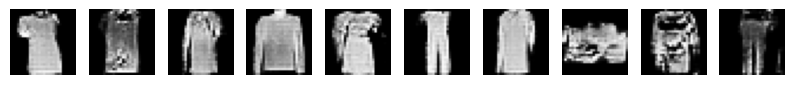

Epoch [16/20], Step [200/938], d_loss: 0.3991, g_loss: 1.3924, D(x): 0.87, D(G(z)): 0.20
Epoch [16/20], Step [400/938], d_loss: 0.3949, g_loss: 1.6279, D(x): 0.97, D(G(z)): 0.27
Epoch [16/20], Step [600/938], d_loss: 0.5913, g_loss: 2.5682, D(x): 0.72, D(G(z)): 0.16
Epoch [16/20], Step [800/938], d_loss: 0.7268, g_loss: 1.8009, D(x): 0.93, D(G(z)): 0.42
Epoch [17/20], Step [200/938], d_loss: 0.5806, g_loss: 1.8464, D(x): 0.89, D(G(z)): 0.31
Epoch [17/20], Step [400/938], d_loss: 0.4475, g_loss: 1.3278, D(x): 0.92, D(G(z)): 0.26
Epoch [17/20], Step [600/938], d_loss: 0.7001, g_loss: 3.0746, D(x): 0.65, D(G(z)): 0.16
Epoch [17/20], Step [800/938], d_loss: 0.2906, g_loss: 3.0950, D(x): 0.87, D(G(z)): 0.12
Epoch [18/20], Step [200/938], d_loss: 0.4952, g_loss: 1.4705, D(x): 0.95, D(G(z)): 0.31
Epoch [18/20], Step [400/938], d_loss: 0.6968, g_loss: 2.4163, D(x): 0.60, D(G(z)): 0.05
Epoch [18/20], Step [600/938], d_loss: 0.3851, g_loss: 5.1221, D(x): 0.76, D(G(z)): 0.05
Epoch [18/20], Step [

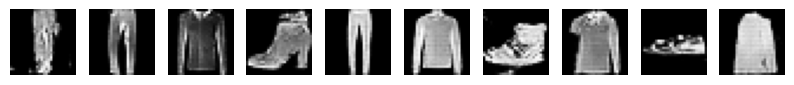

In [ ]:
# cell-8
# Your code here

for epoch in range(num_epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0
    for i, (images, _) in enumerate(trainloader):
        batch_size = images.size(0)
        images = images.to(device)

        # Create labels for training discriminator and generator
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ====================================================================
        # TRAINING DISCRIMINATOR
        # ====================================================================
        # Step1: Infer the discriminator on real images
        outputs = discriminator(images)

        # Step2: Calculate the loss with real labels
        d_real_data_loss = criterion(outputs, real_labels)
        real_score = outputs

        # Step3: Generate random latent vectors from normal distribution
        z = torch.randn(batch_size, latent_dim).to(device)

        # Step4: Generate fake images by passing latent vector to generator
        fake_images = generator(z)

        # Step5: Infer the discriminator on fake images
        outputs = discriminator(fake_images)

        # Step6: Calculate the loss with fake labels
        d_fake_data_loss = criterion(outputs, fake_labels)
        fake_score = outputs

        # Step7: Calculate the total loss
        d_loss = d_real_data_loss + d_fake_data_loss
        d_epoch_loss += d_loss.item()

        # Step8: Update the weights
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()


        # ====================================================================
        # TRAINING GENERATOR
        # ====================================================================

        # Step1: Generate random latent vectors from normal distribution
        z = torch.randn(batch_size, latent_dim).to(device)

        # Step2: Generate fake images by passing latent vector to generator
        fake_images = generator(z)

        # Step3: Infer the discriminator on fake images
        outputs = discriminator(fake_images)

        # Step4: Calculate the loss with real labels
        g_loss = criterion(outputs, real_labels)
        g_epoch_loss += g_loss.item()

        # Step5: Update the weights
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    generator_loss.append(g_epoch_loss / i)
    discriminator_loss.append(d_epoch_loss / i)
    # Visualize the intermediate results
    if (epoch+1) % 5 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        fake_images = fake_images.detach().cpu().numpy()

        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            ax[i].imshow(fake_images[i, 0], cmap='gray')
            ax[i].axis('off')
        plt.show()


### Saving Models

In [ ]:
# cell-9
torch.save(generator, 'generator1.pt')
torch.save(discriminator, 'discriminator1.pt')

### Plotting Learning Curves

In [ ]:
# cell-10
import matplotlib.pyplot as plt

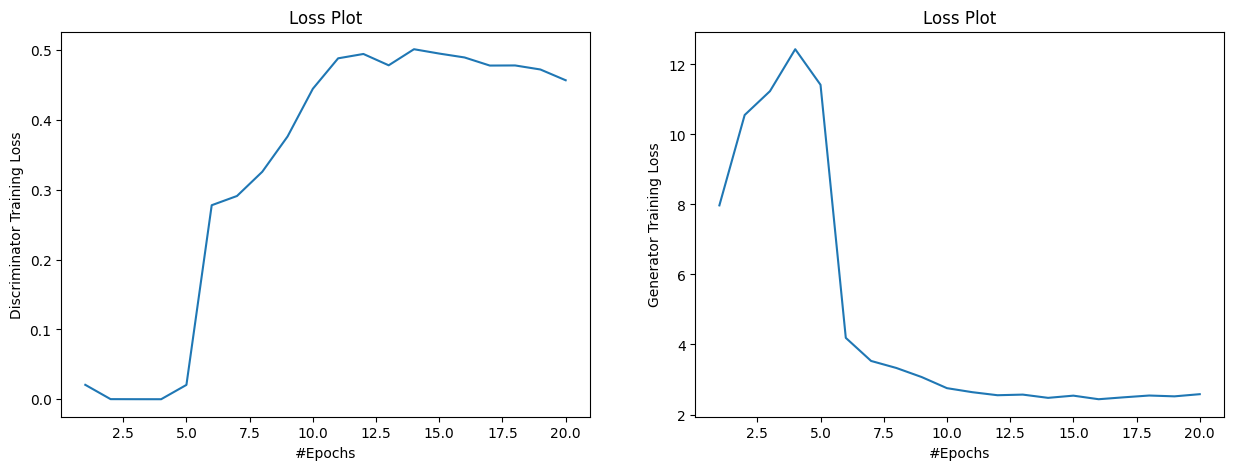

In [ ]:
# cell-11

plt.figure(figsize=(15, 5))

# Subplot for discriminator and generator loss
plt.subplot(1, 2, 1)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, discriminator_loss)
plt.xlabel("#Epochs")
plt.ylabel("Discriminator Training Loss")

plt.subplot(1, 2, 2)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("#Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

### Generating Images by Inferencing Trained GAN

* For inferencing, we need only Generator Network.

* First we need to create a latent vector of normal distribution to feed it to generator.

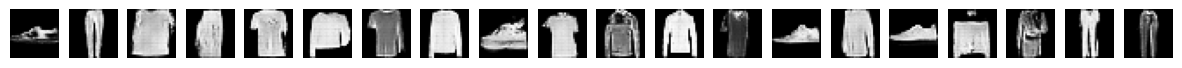

In [ ]:
# cell-12
# Your code here

# Load the model
generator = torch.load('generator1.pt', weights_only=False)

# Set the generator to evaluation mode
generator.eval()

generator

# # Generate latent vectors
num_samples = 20
input_noise = torch.randn(num_samples, latent_dim).to(device)
input_noise = input_noise.view(input_noise.size(0), input_noise.size(1), 1, 1)

# # Generate image using latent vectors
generated_samples = generator(input_noise)

generated_samples_np = generated_samples.detach().cpu().numpy()

# Visualize the generated samples
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    axes[i].imshow(generated_samples_np[i, 0], cmap='gray')
    axes[i].axis('off')
plt.show()

### Explore Different GANs
1. DCGANs
2. Condition GANs
3. Wasserstein GANs
4. Progressive GANs
5. StyleGANs
6. CycleGANs
7. StarGANs